In [1]:
import glob
import os
import cv2
import glob
import importlib
import h5py
import json
import copy
import _pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib as mpl
import scipy.stats as spstats

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg
import analyze2p.scatter as sct

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
pplot.set_plot_params()
scatter_kws={'s':2}

In [4]:
# Metadata
visual_areas=['V1', 'Lm', 'Li']
traceid='traces001'
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


## Load RF fits (aggr)

In [5]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [6]:
response_type='dff'
do_spherical_correction=False
# ------------------------------------
rfdf = rfutils.aggregate_fits(cells0, meta, combine='single', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
count_rfs = aggr.count_n_cells(rfdf)
print(count_rfs.groupby('visual_area').sum())

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
             n_cells
visual_area         
Li               419
Lm               351
V1               814


# Load gradient results

In [7]:
# dk = '20191111_JC117_fov1
# dk ='20190617_JC097_fov1'
# dk = '20191006_JC110_fov1'
# dk = '20190522_JC084_fov1'

In [8]:
#dk='20190617_JC099_fov1'
dk='20191111_JC117_fov2'
va='Lm'

# dk='20190430_JC078_fov1'
# va='Lm'
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                            create_new=False)

#### Check gradients

<IPython.core.display.Javascript object>


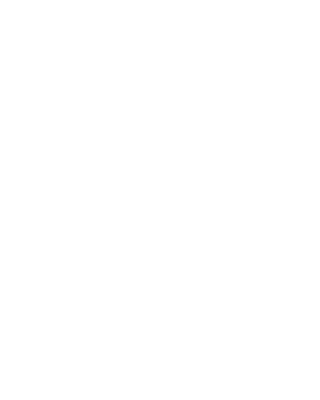

Text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (20191111_JC117_fov2)')

In [9]:
%matplotlib notebook
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral')
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

In [137]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [142]:
retino_np0 = sct.load_neuropil_data(dk, retinorun, mag_thr=None,
            delay_map_thr=1)
retino_np = sct.adjust_retinodf(retino_np0, mag_thr=0.02)
curr_np = retino_np[retino_np.visual_area==va].copy()        

<IPython.core.display.Javascript object>


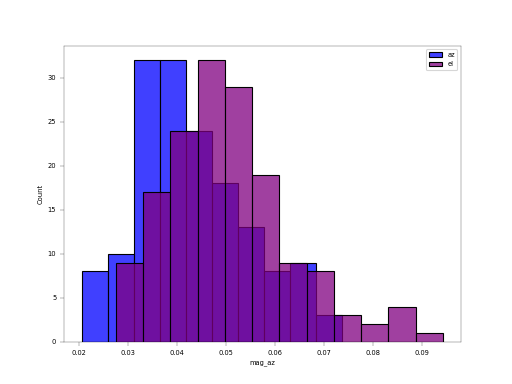

In [145]:
fig, ax = pl.subplots()
sns.histplot(x=curr_np['mag_az'], color='blue', label='az', ax=ax)
sns.histplot(x=curr_np['mag_el'], color='purple', label='el', ax=ax)
ax.legend()

In [158]:
# mag_thr=0.02
# mvb_np = retino_np0.copy()
# el_pass = mvb_np[(mvb_np.mag_el>mag_thr)].index.tolist()
# az_pass = mvb_np[(mvb_np.mag_az>mag_thr)].index.tolist()
# either_pass = np.intersect1d(az_pass, el_pass)


<IPython.core.display.Javascript object>


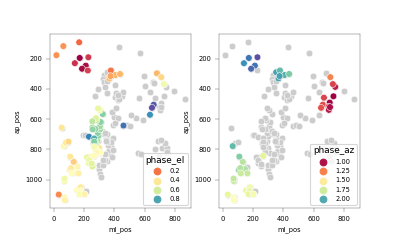

In [160]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(5,3))
ax=axn[0]
sns.scatterplot(x='ml_pos', y='ap_pos', 
                color=[0.8]*3, data=retino_np0, ax=ax, alpha=1)
# sns.scatterplot(x='ml_pos', y='ap_pos', hue='phase_el', 
#                 color=[0.3]*3, data=curr_np, ax=ax, alpha=1)
np_ = mvb_np[mvb_np.mag_el>0.05].copy()
sns.scatterplot(x='ml_pos', y='ap_pos', hue='phase_el', 
                palette='Spectral', data=np_, ax=ax, alpha=1)
ax.set_aspect('equal')
ax.invert_yaxis()

ax=axn[1]
sns.scatterplot(x='ml_pos', y='ap_pos', 
                color=[0.8]*3, data=retino_np0, ax=ax, alpha=1)
np_ = mvb_np[mvb_np.mag_az>0.05].copy()
sns.scatterplot(x='ml_pos', y='ap_pos', hue='phase_az', 
                palette='Spectral', data=np_, ax=ax, alpha=1)
ax.set_aspect('equal')
ax.invert_yaxis()

In [199]:
zimg, dilated_masks, centroids = retutils.dilate_centroids(dk, 
                                        desired_radius_um=100, traceid=traceid)

<IPython.core.display.Javascript object>


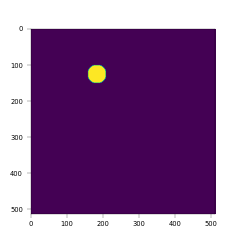

48
48


In [200]:
rid=4
pl.figure(figsize=(3,3))
pl.imshow(dilated_masks[rid, :, :])
x, y = np.where(dilated_masks[rid, :, :]>0)
print(x.max()-x.min())
print(y.max()-y.min())

In [201]:
curr_np.index = curr_np['cell'].values

In [202]:
average_overlap=True
abs_vmin, abs_vmax = (-np.pi, np.pi)
#### Neuropil masks
azim_phase_np, elev_phase_np = retutils.get_phase_masks(dilated_masks, 
                                curr_np['phase_az'], curr_np['phase_el'], 
                                average_overlap=average_overlap, roi_list=None)

In [207]:
scaninfo = retutils.get_protocol_info(dk, run=retinorun)
retinoid, RETID = retutils.load_retino_analysis_info(
                    dk, run=retinorun, use_pixels=False)
# Image dimensions
d2_orig = scaninfo['pixels_per_line']
d1_orig = scaninfo['lines_per_frame']
print("Original dims: [%i, %i]" % (d1_orig, d2_orig))
ds_factor = 1# int(RETID['PARAMS']['downsample_factor'])

Original dims: [512, 512]


In [208]:
# Get pixel size
pixel_size = hutils.get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
d1 = int(d1_orig/ds_factor)
d2 = int(d2_orig/ds_factor)
print(d1, d2)
#### Neuropil:  Transform 2p fov
azim_phase_np_r = retutils.transform_2p_fov(azim_phase_np, pixel_size_ds, 
                                            normalize=False)
elev_phase_np_r = retutils.transform_2p_fov(elev_phase_np, pixel_size_ds, 
                                            normalize=False)
print(azim_phase_np_r.shape)

512 512
(1177, 972)


In [209]:
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)

<IPython.core.display.Javascript object>


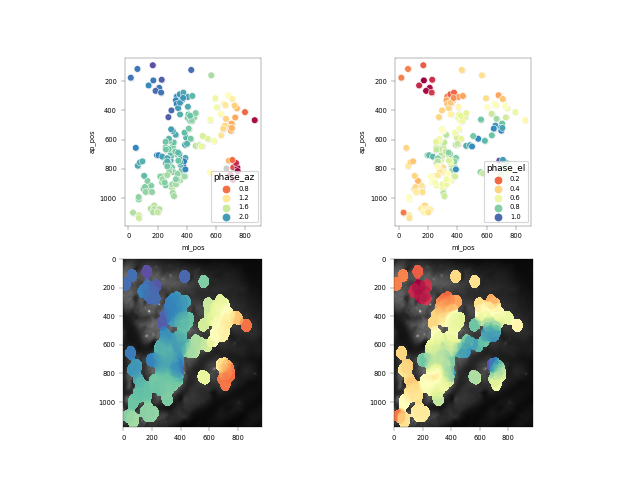

In [210]:
#abs_vmin, abs_vmax = (-np.pi, np.pi)

cmap='Spectral' #pl.get_cmap('cmr.rainforest')
plot_neuropil=True
lw=0.1
np_alpha=0.7

mask_str='neuropil' if plot_neuropil else 'soma'
normalize = mpl.colors.Normalize(vmin=abs_vmin, vmax=abs_vmax)
# cmap = sns.color_palette('nipy_spectral')

fig, axn = pl.subplots(2, 2, figsize=(8,6))
ax=axn[0,0]
sns.scatterplot(x='ml_pos', y='ap_pos', 
                color=[0.8]*3, data=retino_np0, ax=ax, alpha=1)
sns.scatterplot(x='ml_pos', y='ap_pos', hue='phase_az', 
                palette='Spectral', data=curr_np, ax=ax, alpha=1)
ax.set_aspect('equal')
ax.invert_yaxis()

ax=axn[0, 1]
sns.scatterplot(x='ml_pos', y='ap_pos', 
                color=[0.8]*3, data=retino_np0, ax=ax, alpha=1)
np_ = mvb_np[mvb_np.mag_az>0.05].copy()
sns.scatterplot(x='ml_pos', y='ap_pos', hue='phase_el', 
                palette='Spectral', data=curr_np, ax=ax, alpha=1)
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1,0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(azim_phase_np_r, cmap=cmap) #, vmin=abs_vmin, vmax=abs_vmax, 
#               alpha=np_alpha)
ax = axn[1,1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(elev_phase_np_r, cmap=cmap) #, vmin=abs_vmin, vmax=abs_vmax, 
#               alpha=np_alpha)

In [211]:
screen2p_x = 119.5564
screen2p_y = 67.323
resolution2p = [1920, 1080] #[1024, 768]

lmax_az_2p = screen2p_x #/2.
lmin_az_2p = 0 #-screen2p_x #-lmax_az_2p
lmax_el_2p = screen2p_y #/2.
lmin_el_2p = 0 #-screen2p_y# 0 #-lmax_el_2p

In [212]:
# smooth_fwhm = 31 #21
# #azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
# azim_smoothed = retutils.smooth_neuropil(azim_phase_np_r, smooth_fwhm=smooth_fwhm)
# elev_smoothed = retutils.smooth_neuropil(elev_phase_np_r, smooth_fwhm=smooth_fwhm)

# azi_2p_np = hutils.convert_range(azim_smoothed, newmin=lmin_az_2p, newmax=lmax_az_2p,
#                           oldmin=abs_vmin, oldmax=abs_vmax)
# el_2p_np = hutils.convert_range(elev_smoothed, newmin=lmin_az_2p, newmax=lmax_az_2p, 
#                          oldmin=abs_vmin, oldmax=abs_vmax)

<IPython.core.display.Javascript object>


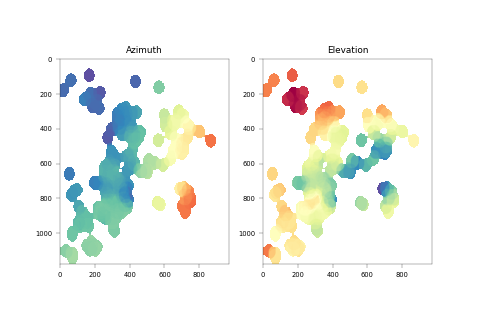

Text(0.5, 1.0, 'Elevation')

In [213]:
fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(azi_2p_np, cmap=cmap) #, vmin=vmin, vmax=vmax, alpha=np_alpha)
ax.set_title("Azimuth")
#ax.legend_.remove()

ax = axn[1]
im = ax.imshow(el_2p_np, cmap=cmap) #, vmin=vmin, vmax=vmax, alpha=np_alpha)
ax.set_title("Elevation")

In [214]:
azi_2p_np = hutils.convert_range(azim_phase_np_r, newmin=lmin_az_2p, newmax=lmax_az_2p,
                          oldmin=abs_vmin, oldmax=abs_vmax)
el_2p_np = hutils.convert_range(elev_phase_np_r, newmin=lmin_az_2p, newmax=lmax_az_2p, 
                         oldmin=abs_vmin, oldmax=abs_vmax)

In [248]:
# nan_smooth_az = seg.fill_and_smooth_nans_missing(azim_phase_np_r, kx=1, ky=1)
# nan_smooth_el = seg.fill_and_smooth_nans_missing(elev_phase_np_r, kx=1, ky=1)
start_az = azim_phase_np_r.copy()
start_el = elev_phase_np_r.copy()
# Get smooth sparams
smooth_spline=1
target_sigma_um=5 # 
sm_azim, sm_elev = seg.smooth_maps(start_az, start_el, 
                            target_sigma_um=target_sigma_um, #smooth_fwhm=smooth_fwhm, 
                            smooth_spline=(smooth_spline, smooth_spline), 
                            fill_nans=True,
                            start_with_transformed=True, 
                            use_phase_smooth=False, ds_factor=1)


Target: 5 (fwhm=2, k=(1, 1))
start 0.0 2.2430864943892637
smoothed 0.0 2.2430864943892646


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1142: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:267: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:268: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 0.7454655694462251 2.2430864943892646
fillnan 0.7454655694462251 2.2430864943892646


In [249]:
# sm_azim.keys()
nan_smooth_az = sm_azim['final']
nan_smooth_el = sm_elev['final']

In [250]:
# screen info
screen = hutils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max
screen
#### Convert to screen units
vmin, vmax = (-np.pi, np.pi)
img_az = hutils.convert_range(nan_smooth_az, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = hutils.convert_range(nan_smooth_el, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)   

Text(0.5, 1.0, 'Elevation')

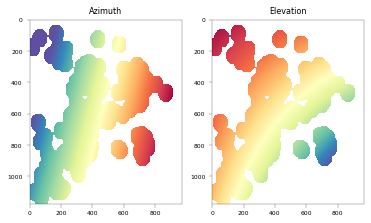

In [251]:
fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(nan_smooth_az, cmap=cmap) #, vmin=vmin, vmax=vmax, alpha=np_alpha)
ax.set_title("Azimuth")
#ax.legend_.remove()

ax = axn[1]
im = ax.imshow(nan_smooth_el, cmap=cmap) #, vmin=vmin, vmax=vmax, alpha=np_alpha)
ax.set_title("Elevation")

In [252]:
# Segmenting params
sign_map_thr = 0.5
min_region_area = 6000 #2000
cmap_phase='Spectral'
# -------------------------------------------------------------------
# Create sign map 
if target_sigma_um < 5: #5:
    print("smoothing")
    img_az2 = retutils.smooth_neuropil(nan_smooth_az, smooth_fwhm=3)
    img_el2 = retutils.smooth_neuropil(nan_smooth_el, smooth_fwhm=3)

    O, S_thr = seg.segment_areas(img_az2, img_el2, sign_map_thr=sign_map_thr)
    fig, ax =pl.subplots(1,2, figsize=(8,3))
    ax[0].imshow(img_az2, cmap=cmap_phase)
    ax[1].imshow(img_el2, cmap=cmap_phase)
else:
    O, S_thr = seg.segment_areas(nan_smooth_az, nan_smooth_el, sign_map_thr=sign_map_thr)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:493: RuntimeWarning: invalid value encountered in greater
  S_thr[O>(O_sigma*sign_map_thr)] = 1
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:494: RuntimeWarning: invalid value encountered in less
  S_thr[O<(-1*O_sigma*sign_map_thr)] = -1


Text(0.01, 0.9, '20191111_JC117_fov2')

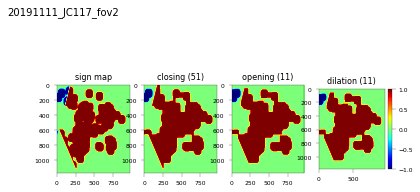

In [253]:
absolute_S_thr=False
close_k = 51
open_k = 11
dilate_k = 11
#S=S_thr.copy() #np.sign(O) # Discretize into patches
S = abs(S_thr) if absolute_S_thr else S_thr.copy()
S[np.isnan(O)]=0

# Morphological steps
S, closing_s1, opening_s1, dilation = seg.do_morphological_steps(S,
                                            close_k=close_k, open_k=open_k, dilate_k=dilate_k)

sfig = seg.plot_morphological_steps(S, closing_s1, opening_s1, dilation, 
                                            close_k=close_k, open_k=open_k, dilate_k=dilate_k) 

sfig.text(0.01, 0.9, dk)

In [254]:
#### Get surface img
surface_img = retutils.load_2p_surface(dk, ch_num=1, retinorun=retinorun)
pixel_size = hutils.get_pixel_size()
surface_2p = retutils.transform_2p_fov(surface_img, pixel_size, normalize=False)
surface_2p = pplot.adjust_image_contrast(surface_2p, clip_limit=10.0, tile_size=5)

(1177, 972) (1177, 972, 3)
Found 2 regions: [1, 2]


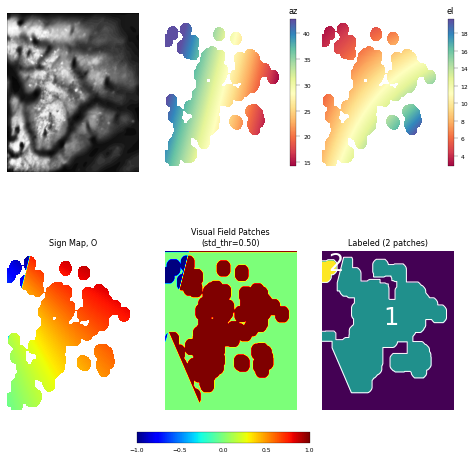

In [255]:
#### Label image
region_props, labeled_image  = seg.segment_and_label(dilation, 
                                        min_region_area=min_region_area)
region_labels = [region.label for region in region_props]
print('Found %i regions: %s' % (len(region_labels), str(region_labels)))
##### Save
orig_d1, orig_d2 = surface_2p.shape
labeled_image_2p = cv2.resize(labeled_image.astype(np.uint8), (orig_d2, orig_d1))
results = {'labeled_image_ds': labeled_image, 
           'labeled_image': labeled_image_2p,
           'region_props': region_props}
fig = seg.plot_segmentation_steps(img_az, img_el, surface=surface_2p, O=O, S_thr=S_thr, 
                                params=seg_params, cmap=cmap_phase, 
                                labeled_image=labeled_image, region_props=region_props, 
                                label_color='w')

Lm 491091


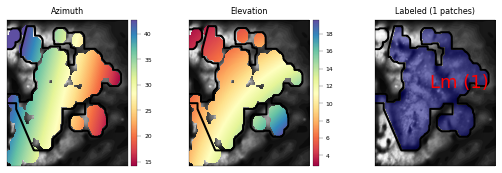

In [256]:
region_dict={1: 'Lm'} #, 2:'Li'} #, 2:'Lm'} #, 3: 'V1', 2: 'Lm'} #,5:'Lm'} #, 2: 'AL', 4: 'Li'} #V1'}
start_with_transformed=True

#region_dict.update(dict( (i, 'Ll') for i in [3]))

#region_dict={1: 'Lm'} #,5:'Lm'} #, 2: 'AL', 4: 'Li'} #V1'}
seg_areas = {}
for ri, region in enumerate(region_props):
    region_id = region.label
    if region.label in region_dict.keys():
        region_name = region_dict[region.label]
    else:
        region_name = region.label
    # save mask
    region_mask = np.copy(labeled_image.astype('float'))
    region_mask[labeled_image != region_id] = 0
    region_mask[labeled_image == region_id] = 1
    if region_name in seg_areas.keys():
        region_mask = seg_areas[region_name]['mask'] + region_mask # Update region mask
        region_id = seg_areas[region_name]['id']
        labeled_image[region_mask==1] = seg_areas[region_name]['id'] # Update labeled image
    seg_areas[region_name] = {'id': region_id, 'mask': region_mask}

# double check labeling/naming of segmented areas
label_keys = [(k, v['id']) for k, v in seg_areas.items() if not(hutils.isnumber(k))]
results.update({'areas': seg_areas})
results.update({'label_keys': label_keys})

# Plot results with segmented areas
pos_multiplier = (1,1) if start_with_transformed else (pixel_size[0], pixel_size[1]) 
area_ids = [k[1] for k in label_keys]
labeled_image_incl = np.ones(labeled_image.shape)*np.nan #labeled_image.copy()
for idx in area_ids:
    labeled_image_incl[labeled_image==idx] = idx

fig = seg.plot_labeled_areas(img_az, img_el, surface_2p, label_keys,
                        labeled_image_2p, labeled_image_incl,
                        region_props, cmap_phase=cmap_phase, pos_multiplier=pos_multiplier)
pl.subplots_adjust(wspace=0.3, top=0.8)

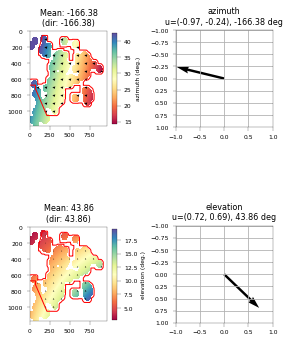

In [257]:
curr_segmented_mask = seg_areas['Lm']['mask']

grad_az, grad_el = seg.calculate_gradients(curr_segmented_mask, img_az, img_el)
# Plot results ------------
%matplotlib inline
contour_lc='r'
contour_lw=1
spacing =100
scale = 0.001 #0.0001
width = 0.01 #1 #0.01
headwidth=5
curr_labeled_image = np.zeros(labeled_image.shape)
curr_labeled_image[labeled_image==seg_areas['Lm']['id']] = 1
fig = seg.plot_gradients_in_area(curr_labeled_image, img_az, img_el, 
                             grad_az, grad_el, cmap_phase=cmap_phase,
                             contour_lc=contour_lc, contour_lw=contour_lw, 
                             spacing=spacing, 
                             scale=scale, width=width, headwidth=headwidth)

# Fit PIXEL MAPS

In [363]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

... calculating global gradients (20190509_JC078_fov1, Lm)
Target: 25 (fwhm=12, k=(1, 1))
start -0.6828501428963613 2.945115835616852


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1142: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


smoothed -0.10753570234344642 2.7229741477958163


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:267: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:268: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 1.0212289433761426 2.7229741477958163
fillnan 1.0212289433761426 2.7229741477958163
    found: 20190509_JC078_fov1, Lm dict_keys(['Lm', 'V1'])


<IPython.core.display.Javascript object>


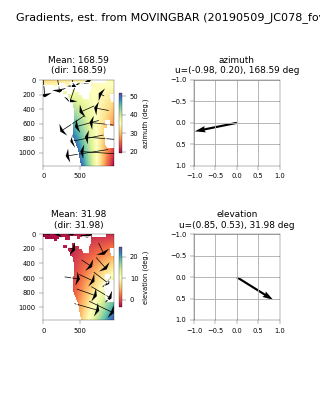

Text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (20190509_JC078_fov1)')

In [6]:
# dk='20191006_JC110_fov1'
# dk='20190522_JC084_fov1'
# va='V1'
# dk='20190602_JC091_fov1'
# va='Li'

dk='20190509_JC078_fov1' #''20191111_JC117_fov2'
va='Lm'

# va='Lm'
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                            create_new=True)

%matplotlib notebook
fig = sct.plot_gradients(dk, va, retinorun, cmap='Spectral')
fig.text(0.05, 0.95, 'Gradients, est. from MOVINGBAR (%s)' % dk)

In [7]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [389]:
# retinorun, AZMAP_NP, ELMAP_NP, GVECTORS, REGR_NP = sct.get_gradient_results(dk, va,
#                                                         do_model=True)

#### Load segmentation 

In [8]:
seg_results, seg_params = seg.load_segmentation_results(dk, retinorun=retinorun)
segmented_areas = seg_results['areas']
area_results = segmented_areas[va].copy()
curr_segmented_mask = area_results['mask']

In [9]:
thr_img_az = AZMAP_NP.copy() 
thr_img_az[curr_segmented_mask==0] = np.nan     

thr_img_el = ELMAP_NP.copy() 
thr_img_el[curr_segmented_mask==0] = np.nan  

<IPython.core.display.Javascript object>


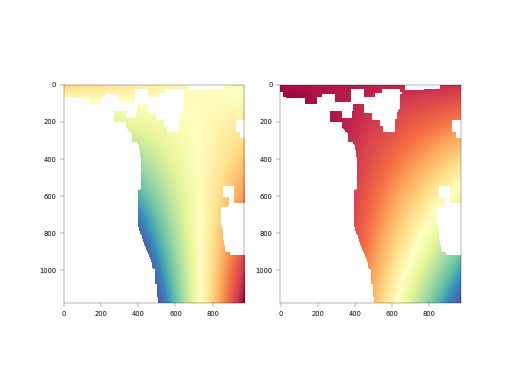

In [10]:
fig, axn = pl.subplots(1,2)
ax=axn[0]
ax.imshow(thr_img_az, cmap='Spectral')
ax=axn[1]
ax.imshow(thr_img_el, cmap='Spectral')

In [11]:
d1, d2 = ELMAP_NP.shape
print(d1, d2)

# Get coordinates of each pixel
Y, X = np.mgrid[0:d1, 0:d2]
positions = np.array([(i, j) for i, j in zip(X.ravel(),Y.ravel())])
#np.vstack([X.ravel(), Y.ravel()]).astype(int).T

assert d1*d2 == len(positions)

1177 972


In [12]:
pixel_pos = pd.DataFrame({'ml_pos': positions[:, 0], 'ap_pos': positions[:, 1]})

In [13]:
# rot_mat = np.array([[1, 0], [0, -1]])
# rot_mat = np.array([[-1, 0], [0, 1]])
# rot_mat = np.array([[0, 1], [1, 0]])
# rot_mat = np.array([[0, -1], [1, 0]])

# u1=GVECTORS['az'].copy()
# u2=GVECTORS['el'].copy() ##GVECTORS['el'].copy()
# transf_df, M = sct.apply_projection(pixel_pos, u1, u2,
#                                  xlabel='ml_proj', ylabel='ap_proj', abs_value=False)

# M = np.array([[u1[0], u1[1]],
#               [u2[0], u2[1]]])
# M
# # transf_vs = [np.matmul(M, np.array([x, y])) for (x, y) \
# transf_vs = [M@np.array([x, y]) for (x, y) \
#              in pixel_pos[['ml_pos', 'ap_pos']].values]
# pixel_proj = pd.DataFrame(transf_vs, columns=['ml_proj', 'ap_proj'], \
#                  index=pixel_pos.index)
pixel_proj, M = sct.project_onto_gradient(pixel_pos, GVECTORS)

In [15]:
# pixel_proj['ml_proj_ix'] = [int(round(i)) for i in pixel_proj['ml_proj']]
# pixel_proj['ap_proj_ix'] = [int(round(i)) for i in pixel_proj['ap_proj']]
# pix_df = pd.merge(pixel_pos, pixel_proj, left_index=True, right_index=True)
# print(pix_df.shape)
pixel_proj['ml_proj_ix'] = [d2+int(round(i)) if i<0 else int(round(i))\
                            for i in pixel_proj['ml_proj']]
pixel_proj['ap_proj_ix'] = [d1+int(round(i)) if i<0 else int(round(i))\
                            for i in pixel_proj['ap_proj']]
#pix_df = pd.merge(pixel_pos, pixel_proj, left_index=True, right_index=True)
pix_df = pd.concat([pixel_proj, pixel_pos], axis=1)
pix_df.shape
pix_df.tail()

,ml_proj,ap_proj,ml_proj_ix,ap_proj_ix,ml_pos,ap_pos
1144039,-715.218846,1443.090099,257,1443,967,1176
1144040,-716.199080,1443.938319,256,1444,968,1176
1144041,-717.179313,1444.786539,255,1445,969,1176
1144042,-718.159546,1445.634759,254,1446,970,1176
1144043,-719.139779,1446.482979,253,1446,971,1176


<IPython.core.display.Javascript object>


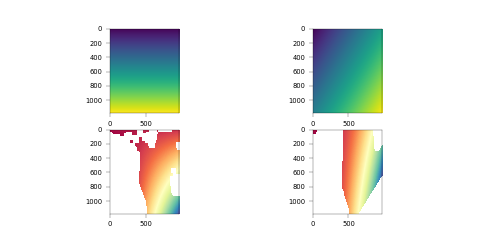

In [16]:

# p_el = [AZMAP_NP[i, j] if (i<d1 and j<d2) \
#                                     else np.nan for (i, j) \
#                                 in pix_df[['ap_pos', 'ml_proj_ix']].values]

p_el = [ELMAP_NP[i, j] if (i<d1 and j<d2) \
                                    else np.nan for (i, j) \
                                in pix_df[['ap_proj_ix', 'ml_pos']].values]

axlabel= 'ap'
fig, axn = pl.subplots(2,2, figsize=(6,3))
ax=axn[0,0]
orig_el = np.reshape(pix_df['%s_pos' % axlabel].values, (d1, d2))
ax.imshow(orig_el)
ax=axn[0,1]
proj_el = np.reshape(pix_df['%s_proj' % axlabel].values, (d1, d2))
ax.imshow(proj_el)

ax=axn[1,0]
ax.imshow(ELMAP_NP, cmap='Spectral')

ret_ = np.reshape(p_el, (d1, d2))
ax=axn[1,1]
ax.imshow(ret_, cmap='Spectral')

In [323]:
# fig, ax = pl.subplots()
# sns.scatterplot(x='ap_pos', y='ap_proj', data=pix_df.iloc[0::1177], 
#                 markers='.', s=1)
# sns.scatterplot(x='ap_pos', y='ap_pos', data=pix_df.iloc[0::1177], 
#                 markers='.', s=1, color='k')
# sns.scatterplot(x='ap_pos', y='ap_proj', data=pix_df.iloc[0::972], 
#                 markers='.', s=1, color='r')
# ax.set_aspect('equal')

In [324]:
# x = [970, 1176]
# u1.dot(x), u2.dot(x)

In [315]:
# fig, axn = pl.subplots(1,2, figsize=(6,3))
# ax=axn[0]
# orig_el = np.reshape(pix_df['ap_pos'].values, (d1, d2))
# ax.imshow(orig_el)
# ax=axn[1]
# proj_el = np.fliplr(np.reshape(pix_df['ap_proj_ix'].values, (d1, d2)))
# ax.imshow(proj_el)

In [316]:
# p_el = [ELMAP_NP[i, j] if (i<d1 and j<d2) \
#                                     else np.nan for (i, j) \
#                                 in pix_df[['ap_proj_ix', 'ml_pos']].values]

In [317]:
# %matplotlib inline

# proj_el = np.reshape(p_el, (d1, d2))

# fig, axn = pl.subplots(1,2, figsize=(6,3))
# ax=axn[0]
# im0=ax.imshow(ELMAP_NP, cmap='Spectral')
# pl.colorbar(im0, ax=ax, orientation='vertical', shrink=0.7)
# ax=axn[1]
# ax.imshow(proj_el, cmap='Spectral')

In [19]:

#pixel_pos = pd.DataFrame({'ml_pos': positions[:, 0], 'ap_pos': positions[:, 1]})
#posdf = pd.concat([pixel_proj, pixel_pos], axis=1)

retino_val = pd.DataFrame({'x0': [AZMAP_NP[j, i] for (i,j) in positions],
                           'y0': [ELMAP_NP[j, i] for (i, j) in positions]})

aligned_pix = pd.merge(retino_val, pix_df, left_index=True, right_index=True)

In [20]:
regr_meas = sct.regress_cortex_and_retino_pos(aligned_pix.dropna(),
                                  xvar='pos', model='ridge')
regr_proj = sct.regress_cortex_and_retino_pos(aligned_pix.dropna(),
                                  xvar='proj', model='ridge')
print("PIX, MEASURED:")
print(regr_meas.to_markdown())
print("PIX, ALIGNED:")
print(regr_proj.to_markdown())

PIX, MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.319643 | 4.57214 |           0 |   -0.56537  |    -0.01617   |    47.5486  | az     |
|  1 | 0.663621 | 3.35364 |           0 |    0.814629 |     0.0136821 |    -2.49672 | el     |
PIX, ALIGNED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.396461 | 4.3063  |           0 |    0.629651 |     0.0187289 |     46.9333 | az     |
|  1 | 0.838623 | 2.32286 |           0 |    0.915763 |     0.0194418 |    -11.4168 | el     |


In [21]:
# importlib.reload(sct)

In [22]:
aligned_pix = sct.predict_positions(aligned_pix, M, regr_proj)
# REGR_NP = regr_proj.copy()
# #### Predict CORTICAL position (from retino position)
# p_x = predict_cortex_position(REGR_NP, cond='az', 
#                           points=aligned_pix['x0'].values)
# p_y = predict_cortex_position(REGR_NP, cond='el', 
#                           points=aligned_pix['y0'].values)
# aligned_pix['predicted_ml_proj'] = p_x
# aligned_pix['predicted_ap_proj'] = p_y

# #### Predict RETINO position (from cortical position)
# r_x = predict_retino_position(REGR_NP, cond='az', 
#                           points=aligned_pix['ml_proj'].values)
# r_y = predict_retino_position(REGR_NP, cond='el', 
#                           points=aligned_pix['ap_proj'].values)
# aligned_pix['predicted_x0'] = r_x
# aligned_pix['predicted_y0'] = r_y

# #### Calculate inverse for visualizing on FOV
# pred_INV = [np.linalg.inv(M).dot(np.array([x, y])) for (x, y) \
#             in aligned_pix[['predicted_ml_proj', 'predicted_ap_proj']].values]
# pred_inv_df = pd.DataFrame(pred_INV, columns=['pred_inv_x', 'pred_inv_y'], 
#                       index=aligned_soma.index)
# aligned_pix['predicted_ml_pos'] = pred_inv_df['pred_inv_x']
# aligned_pix['predicted_ap_pos'] = pred_inv_df['pred_inv_y']


In [329]:
# def plot_linear_fit_and_scatter(aligned_pix, regr_meas, x_var='ml_pos', y_var='x0',
#                                 cond_name=None,
#                                 spacing=500, markers='.', s=1, mc='k', 
#                                 lc='m', lw=1, ax=None):
#     if ax is None:
#         fig, ax = pl.subplots()
#     if cond_name is None:
#         cond_name = 'az' if ('ml' in x_var or 'x' in y_var) else 'el'
#     sns.scatterplot(x=x_var, y=y_var, data=aligned_pix.iloc[0::spacing], ax=ax, 
#                markers=markers, s=s, color=mc)
#     R2 = float(regr_meas[regr_meas.cond==cond_name]['R2'])
#     RMSE = float(regr_meas[regr_meas.cond==cond_name]['RMSE'])
#     prefix = '[%s] R2=%.2f, RMSE=%.2f\n' % (cond_name, R2, RMSE)
#     slope = float(regr_meas[regr_meas.cond==cond_name]['coefficient'])
#     intercept = float(regr_meas[regr_meas.cond==cond_name]['intercept'])
#     ax = pplot.abline(slope, intercept, ax=ax, lw=lw, color=lc, 
#                       label=x_var, label_prefix=prefix)
#     return ax


In [330]:
%matplotlib notebook

<IPython.core.display.Javascript object>


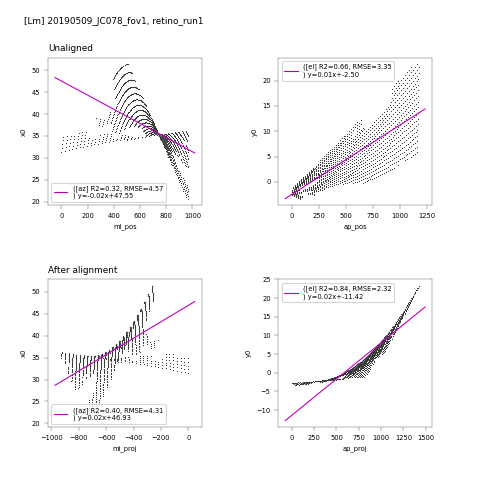

Text(0.05, 0.95, '[Lm] 20190509_JC078_fov1, retino_run1')

In [25]:
lc='m'
lw=1

fig, axn = pl.subplots(2,2, figsize=(6,6))
# plot measured
ax=axn[0,0]
ax.set_title('Unaligned', loc='left')
ax = sct.plot_linear_fit_and_scatter(aligned_pix, regr_meas, ax=ax,
                                 x_var='ml_pos', y_var='x0', lc=lc, lw=lw)
ax=axn[0,1]
ax = sct.plot_linear_fit_and_scatter(aligned_pix, regr_meas, ax=ax,
                                 x_var='ap_pos', y_var='y0', lc=lc, lw=lw)
# plot fit
ax=axn[1,0]
ax.set_title('After alignment', loc='left')
ax = sct.plot_linear_fit_and_scatter(aligned_pix, regr_proj, ax=ax,
                                 x_var='ml_proj', y_var='x0', lc=lc, lw=lw)
ax=axn[1,1]
ax = sct.plot_linear_fit_and_scatter(aligned_pix, regr_proj, ax=ax,
                                 x_var='ap_proj', y_var='y0', lc=lc, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, hspace=0.5)

#pplot.label_figure(fig, data_id)
fig.text(0.05, 0.95, '[%s] %s, %s' % (va, dk, retinorun), fontsize=8)

In [192]:
# aligned_pix['ap_pos'] = aligned_ap_pos

In [332]:
aligned_pix['ml_proj_ix'] = [i if np.isnan(i) else int(round(i))\
                            for i in aligned_pix['ml_proj'].values]
aligned_pix['ap_proj_ix'] = [i if np.isnan(i) else int(round(i))\
                            for i in aligned_pix['ap_proj'].values]
# aligned_pix['pred_ap_ix'] = [d1+int(round(i)) if i<0 else int(round(i))\
#                             for i in aligned_pix['predicted_ap_pos']]

In [333]:
# df = pd.DataFrame({'x0_proj': [AZMAP_NP[int(i), int(j)] if (not np.isnan(i)) \
#                                    and (i<d1 and j<d2) \
#                                     else i for (i, j) \
#                                 in aligned_pix[['ap_pos', 'ml_proj_ix']].values],
#                     'y0_proj': [ELMAP_NP[int(i), int(j)] if (not np.isnan(i)) \
#                                     and (i<d1 and j<d2) \
#                                     else np.nan for (i, j) \
#                                 in aligned_pix[['ap_proj_ix', 'ml_pos']].values]
#                            })

In [334]:
aligned_pix['predicted_ml_pos_ix'] = [d2+int(round(i)) if i<0 else i\
                             for i in aligned_pix['predicted_ml_pos']]
aligned_pix['predicted_ap_pos_ix'] = [d1+int(round(i)) if i<0 else i\
                             for i in aligned_pix['predicted_ap_pos']]

In [335]:
# pred_x = aligned_pix.loc[aligned_pix['ml_pos'].values, 'predicted_x0'].values
# pred_y = aligned_pix.loc[aligned_pix['ap_pos'].values, 'predicted_y0'].values

# pred_x = [AZMAP_NP[int(i), int(j)] if (not np.isnan(i)) \
#                                    and (i<d1 and j<d2) \
#                                     else i for (i, j) \
#                                 in aligned_pix[['ap_pos', 'ml_proj_ix']].values],
# pred_y = [ELMAP_NP[int(i), int(j)] if (not np.isnan(i)) \
#                                     and (i<d1 and j<d2) \
#                                     else np.nan for (i, j) \
#                                 in aligned_pix[['pred_ap_ix', 'ml_pos']].values]

#### Get scatttered pix

In [336]:
s = sct.calculate_scatter(aligned_pix)

<IPython.core.display.Javascript object>


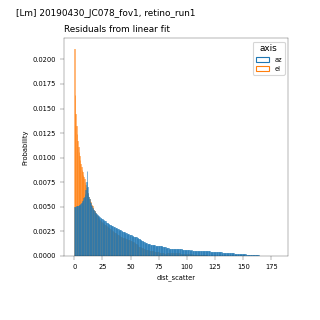

In [337]:
fig, ax= pl.subplots(figsize=(4,4))
sns.histplot(x='dist_scatter', hue='axis', data=s, ax=ax,
            stat='probability', fill=False, common_norm=True)
ax.set_title('Residuals from linear fit', loc='left')
fig.text(0.05, 0.95, '[%s] %s, %s' % (va, dk, retinorun), fontsize=8)
pl.subplots_adjust(left=0.2, right=0.9, bottom=0.2)

<IPython.core.display.Javascript object>


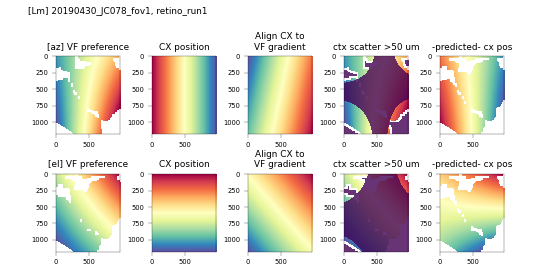

In [339]:
scatter_lim = 50

cmap='Spectral'
fig, axn = pl.subplots(2,5, figsize=(7,3.5))

for ai, axlabel in enumerate(['ml', 'ap']):
    # axlabel= 'ap'
    np_map = ELMAP_NP.copy() if axlabel=='ap' else AZMAP_NP
    cond_name= 'el' if axlabel=='ap' else 'az'
    scattered_ = s[(s.axis==cond_name) \
                 & (s.dist_scatter>scatter_lim)]['cell'].dropna().astype(int).unique()
    # Mask of scattered pixels
    all_pix = np.ones_like(aligned_pix.index.to_numpy()).astype(float)
    all_pix[scattered_] = np.nan
    all_plot = np.reshape(all_pix, (d1, d2))

    ax=axn[ai,0]
    ax.set_title("[%s] VF preference" % cond_name)
    ax.imshow(np_map, cmap=cmap)

    ax=axn[ai,1]
    ax.set_title("CX position")
    orig_el = np.reshape(aligned_pix['%s_pos' % axlabel].values, (d1, d2))
    ax.imshow(orig_el, cmap=cmap)

    ax=axn[ai,2]
    ax.set_title("Align CX to\nVF gradient")
    proj_el = np.reshape(aligned_pix['%s_proj' % axlabel].values, (d1, d2))
    ax.imshow(proj_el,cmap=cmap)

    ax=axn[ai,3]
    ax.set_title("ctx scatter >%i um" % scatter_lim)
    ax.imshow(np_map, cmap=cmap)
    ax.imshow(all_plot, alpha=0.8)

    ax=axn[ai, 4]
    ax.set_title('-predicted- cx pos')
    proj_el = np.reshape(aligned_pix['predicted_%s_pos' % axlabel].values, (d1, d2))
    ax.imshow(proj_el, cmap=cmap)

fig.text(0.05, 0.95, '[%s] %s, %s' % (va, dk, retinorun), fontsize=8)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.5, hspace=0.5, top=0.8)

In [547]:
vhat_az = GVECTORS['az']
vhat_el = GVECTORS['el']
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) \
                    for xv in np.arange(0, d2)])
proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) \
                    for xv in np.arange(0, d2)])
pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])


In [548]:
ret_az = np.array([AZMAP_NP[xv, yv] for xv in np.arange(0, d1) \
                   for yv in np.arange(0, d2)] )
ret_el = np.array([ELMAP_NP[xv, yv] for xv in np.arange(0, d1) \
                   for yv in np.arange(0, d2)] )


In [549]:
d1, d2

(1177, 972)

In [550]:
#proj_el_ix = pix.copy()
proj_el_ix = np.array([int(round(i)) \
                                     for i in proj_el])

In [551]:
test = ret_el[proj_el_ix]
#test[np.isnan(proj_el)] = np.nan

<IPython.core.display.Javascript object>


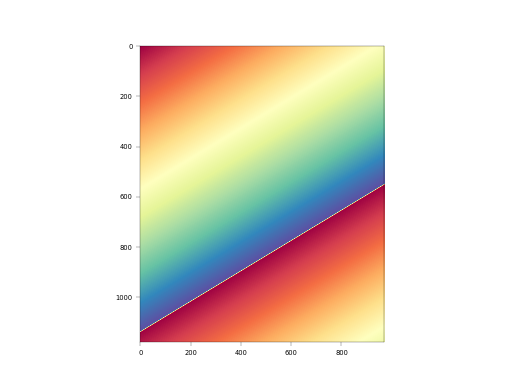

In [552]:
pl.figure()
pl.imshow(np.reshape(test, (d1, d2)), cmap='Spectral')

In [510]:
# u1=GVECTORS['az']
# u2=GVECTORS['el']

# M = np.array([[u1[0], u1[1]],
#              [u2[0], u2[1]]])
# M
# transf_vs = [np.matmul(M, np.array([x, y])) for (x, y) in pixel_pos[['ml_pos', 'ap_pos']].values]
# proj = pd.DataFrame(transf_vs, columns=['ml_proj', 'ap_proj'], index=pixel_pos.index)


In [445]:
# transf_vs = [np.matmul(M, np.array([x, y])) for (x, y) in pixel_pos[['ml_pos', 'ap_pos']].values]


In [447]:
# proj = pd.DataFrame(transf_vs, columns=['ml_proj', 'ap_proj'], index=pixel_pos.index)


<IPython.core.display.Javascript object>


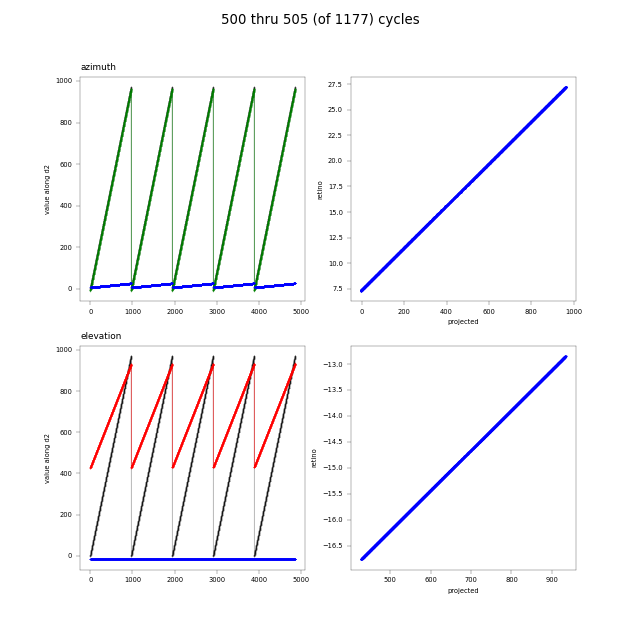

Text(0, 0.5, 'retino')

In [464]:
ncyc=5
startcyc=500
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc

fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.set_title('azimuth', loc='left')
#ax.plot(pixel_pos['ml_pos'][spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
#ax.plot(proj['ml_proj'][spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
#ax.plot(retino_val['x0'][spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'g',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b',  marker='.', lw=0.5, markersize=0.5)
ax.set_ylabel('value along d2')
ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
#ax.scatter(proj['ml_proj'][spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.set_title('elevation', loc='left')
# ax.plot(pixel_pos['ap_pos'][spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
# ax.plot(proj['ap_proj'][spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
# ax.plot(proj_el[spts:npts], 'g',  marker='.', lw=0.5, markersize=0.5)
# ax.plot(retino_val['y0'][spts:npts], 'b', marker='.', lw=0, markersize=0.5)
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)

ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj['ap_proj'][spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')

<IPython.core.display.Javascript object>


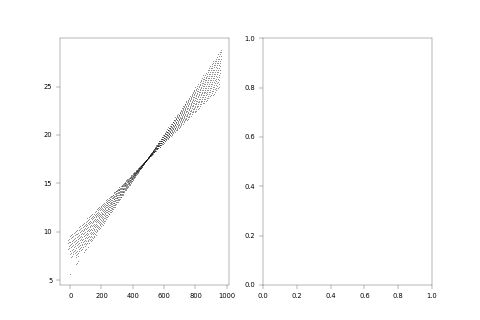

In [482]:
fig, axn = pl.subplots(1,2, figsize=(6, 4))
spacing=800
ax=axn[0]
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)

In [372]:
proj.tail()

,ml_proj,ap_proj,ml_proj_ix,ap_proj_ix
1144039,1211.704664,1448.219379,1212,1448
1144040,1212.677817,1448.585170,1213,1449
1144041,1213.650970,1448.950960,1214,1449
1144042,1214.624124,1449.316751,1215,1449
1144043,1215.597277,1449.682541,1216,1450


In [373]:
retino_df.tail()

,x0,y0,ml_pos,ap_pos,ml_proj,ap_proj
1144039,40.731550,2.670576,967,1176,1211.704664,1448.219379
1144040,40.744631,2.674597,968,1176,1212.677817,1448.585170
1144041,40.757712,2.678619,969,1176,1213.650970,1448.950960
1144042,40.770793,2.682640,970,1176,1214.624124,1449.316751
1144043,40.783874,2.686662,971,1176,1215.597277,1449.682541


In [374]:
proj_retino =  pd.merge(retino_df, proj, on=['ml_proj', 'ap_proj'])

proj_retino.tail()

,x0,y0,ml_pos,ap_pos,ml_proj,ap_proj,ml_proj_ix,ap_proj_ix
1144039,40.731550,2.670576,967,1176,1211.704664,1448.219379,1212,1448
1144040,40.744631,2.674597,968,1176,1212.677817,1448.585170,1213,1449
1144041,40.757712,2.678619,969,1176,1213.650970,1448.950960,1214,1449
1144042,40.770793,2.682640,970,1176,1214.624124,1449.316751,1215,1449
1144043,40.783874,2.686662,971,1176,1215.597277,1449.682541,1216,1450


In [375]:
df = pd.DataFrame({'x0_proj': [AZMAP_NP[i, j] if (not np.isnan(i)) and (i<d1 and j<d2) \
                                else np.nan for (i, j) \
                                in proj_retino[['ap_pos', 'ml_proj_ix']].values],
                    'y0_proj': [ELMAP_NP[i, j] if (not np.isnan(i)) and (i<d1 and j<d2) \
                                else np.nan for (i, j) \
                                in proj_retino[['ap_proj_ix', 'ml_pos']].values]
                           
                           })

In [376]:
proj_az = np.reshape(df['x0_proj'].values, (d1, d2))
proj_el = np.reshape(df['y0_proj'].values, (d1, d2))

# np.reshape(test, (d2, d1)).T)

# proj_az = np.reshape(df['x0_proj'].values, (d2, d1)).T
# proj_el = np.reshape(df['y0_proj'].values, (d2, d1)).T

fig, axn = pl.subplots(2,2, figsize=(6,3))
ax=axn[0,0]
im0=ax.imshow(AZMAP_NP, cmap='Spectral')
pl.colorbar(im0, ax=ax, orientation='vertical', shrink=0.7)
ax=axn[0, 1]
ax.imshow(proj_az, cmap='Spectral')

ax=axn[1,0]
im0=ax.imshow(ELMAP_NP, cmap='Spectral')
pl.colorbar(im0, ax=ax, orientation='vertical', shrink=0.7)
ax=axn[1, 1]
ax.imshow(proj_el, cmap='Spectral')

In [171]:
AZMAP_NP[971, 1176]

IndexError: index 1176 is out of bounds for axis 1 with size 972

In [346]:
old_algn = glob.glob(os.path.join(rootdir, 'JC*', '20*', 'FOV*', 'segmentation', 'alignment.pkl'))
for r in old_algn:
    os.remove(r)

# Smooth within mask

In [302]:
retinorun = sct.get_best_retinorun(dk)
print(retinorun)

# pix_mag_thr=0.001
# delay_map_thr=1.0
pmaps, pparams = seg.get_processed_maps(dk, retinorun=retinorun, create_new=False)
print(list(pmaps.keys()))
pparams

retino_run1
['filtered_az_scaled', 'absolute_el', 'filtered_el_scaled', 'filtered_el', 'absolute_az', 'filtered_az']


{'delay_map_thr': 1.0,
 'ds_factor': 2,
 'pixel_mag_thr': 0.002,
 'retino_run': 'retino_run1',
 'retino_id': 'analysis001',
 'dims': [512, 512],
 'pixel_size': [2.3, 1.9]}

In [266]:
# start_az = pmaps['filtered_az_scaled']
# start_el = pmaps['filtered_el_scaled']

# sm_azim, sm_elev = seg.smooth_maps(start_az, start_el, target_sigma_um=target_sigma_um, #smooth_fwhm=smooth_fwhm, 
#                             smooth_spline=smooth_spline, fill_nans=fill_nans,
#                             smooth_spline_x=smooth_spline_x, smooth_spline_y=smooth_spline_y,
#                             start_with_transformed=start_with_transformed, 
#                             use_phase_smooth=use_phase_smooth, ds_factor=ds_factor)
# az_fill = sm_azim['final']
# el_fill = sm_elev['final']

In [303]:
seg_results, seg_params = seg.load_segmentation_results(dk, retinorun=retinorun)
segmented_areas = seg_results['areas']
area_results = segmented_areas[va].copy()
curr_segmented_mask = area_results['mask']
# ------
start_az = pmaps['filtered_az_scaled']
start_el = pmaps['filtered_el_scaled']

thr_img_az = start_az.copy() 
thr_img_az[curr_segmented_mask==0] = np.nan     

thr_img_el = start_el.copy() 
thr_img_el[curr_segmented_mask==0] = np.nan     

In [318]:
# Get smooth sparams
smooth_spline=1
target_sigma_um=25 # 
#use_phase_smooth=seg_params['use_phase_smooth']
#start_with_transformed=seg_params['start_with_transformed']
sm_azim, sm_elev = seg.smooth_maps(thr_img_az, thr_img_el, 
                            target_sigma_um=target_sigma_um, #smooth_fwhm=smooth_fwhm, 
                            smooth_spline=(smooth_spline, smooth_spline), 
                            fill_nans=True,
                            start_with_transformed=True, 
                            use_phase_smooth=False)
AZMAP_NP = sm_azim['final']
ELMAP_NP = sm_elev['final']

# AZMAP_NP = az_fill.copy()
# ELMAP_NP = el_fill.copy()


Target: 25 (fwhm=12, k=(1, 1))
start -2.4014799636649493 2.5902920257113675


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1142: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


smoothed -1.7695657765646313 2.4786645200766046


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:267: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:268: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan -1.7695657765646313 2.4046941123631482
fillnan -1.7695657765646313 2.4046941123631482


<IPython.core.display.Javascript object>


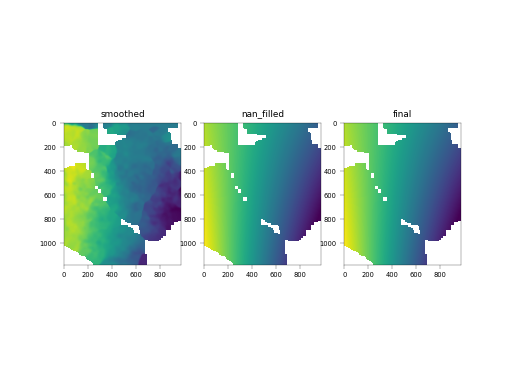

In [344]:
list(sm_azim.keys())
fig, axn = pl.subplots(1,3)
for ax, k in zip(axn.flat, sm_azim.keys()):
    ax.imshow(sm_azim[k])
    ax.set_title(k)

<IPython.core.display.Javascript object>


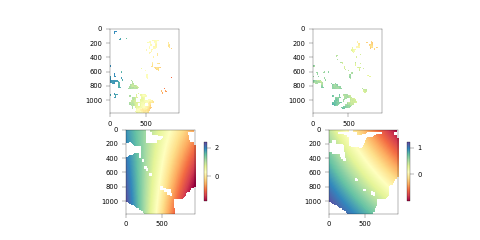

In [341]:
%matplotlib notebook
#test1 = retutils.smooth_array(smooth1, 11, phaseArray=True)
fig, axn = pl.subplots(2,2, figsize=(6,3))
ax=axn[0,0]
ax.imshow(thr_img_az, cmap='Spectral')
ax=axn[0,1]
ax.imshow(thr_img_el, cmap='Spectral')
ax=axn[1,0]
im0 = ax.imshow(AZMAP_NP, cmap='Spectral')
pl.colorbar(im0, ax=ax, orientation='vertical', shrink=0.7)

ax=axn[1,1]
im1 = ax.imshow(ELMAP_NP, cmap='Spectral')
pl.colorbar(im1, ax=ax, orientation='vertical', shrink=0.7)


In [308]:
grad_az, grad_el = seg.calculate_gradients(curr_segmented_mask, az_fill, el_fill)

<IPython.core.display.Javascript object>


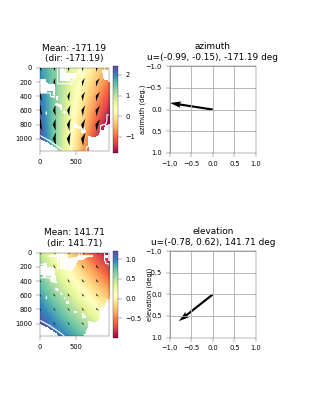

In [309]:
fig = seg.plot_gradients_in_area(curr_segmented_mask, az_fill, el_fill, 
                             grad_az, grad_el, cmap_phase='Spectral',
                             contour_lc='w', contour_lw=1, 
                             spacing=200, 
                             scale=0.0001, width=0.01, headwidth=20)

In [75]:
GVECTORS={'az': grad_az['vhat'], 
          'el': grad_el['vhat']}

In [340]:
grad_az.keys()

dict_keys(['image', 'magnitude', 'gradient_x', 'gradient_y', 'direction', 'mean_deg', 'mean_direction', 'vhat'])

In [76]:
retinodf_np = sct.load_neuropil_data(dk, retinorun, mag_thr=0.01,
                delay_map_thr=1)
# mags_soma, phases_soma, mags_np, phases_np, dims = sct.load_movingbar_results(dk, retinorun)
# mvb_np = retutils.get_final_maps(mags_np, phases_np,
#     trials_by_cond=None, mag_thr=None, dims=dims, ds_factor=ds_factor, use_pixels=False)

curr_np = retinodf_np[retinodf_np.visual_area==va].copy()          

<IPython.core.display.Javascript object>


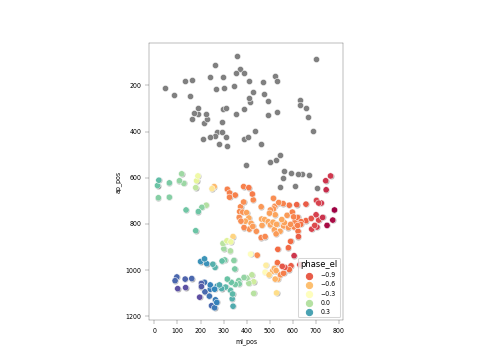

In [77]:
fig, ax = pl.subplots()
sns.scatterplot(x='ml_pos', y='ap_pos', 
                color=[0.5]*3, data=retinodf_np, ax=ax)

sns.scatterplot(x='ml_pos', y='ap_pos', hue='phase_el', 
                palette='Spectral', data=curr_np, ax=ax)

ax.set_aspect('equal')
ax.invert_yaxis()

In [56]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

In [78]:
u1 = GVECTORS['az'].copy()
u2 = GVECTORS['el'].copy()

aligned_, M = sct.apply_projection(curr_np, u1, u2, abs_value=False)
aligned_np = pd.concat([curr_np, aligned_], axis=1).dropna()   


In [79]:
xvar='proj'
r_=[]
for ai, cond in enumerate(['az', 'el']):
    ctx_label = 'ml' if cond=='az' else 'ap'
    # ret_label = 'az_lin' if cond=='az' else 'el_lin'
    ret_label = 'x0' if cond=='az' else 'y0'

    xvs = aligned_np['%s_%s' % (ctx_label, xvar)].values
    yvs = aligned_np['%s' % ret_label].values
    regr_, linmodel = sct.do_linear_fit(xvs, yvs, model='ridge')
    regr_['cond'] = cond
    r_.append(regr_)
regr_tiles = pd.concat(r_).reset_index(drop=True)
regr_tiles

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond
0,0.710443,12.484602,6.859629e-48,0.842878,0.128909,-90.845714,az
1,0.872491,3.503014,2.177030e-78,0.934072,0.048540,-8.929676,el


MEASURED:
|    |       R2 |     RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|---------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.418861 | 17.6867  | 6.55053e-22 |    0.647195 |     0.0826356 |    -7.68825 | az     |
|  1 | 0.310605 |  8.14526 | 1.66848e-15 |    0.557319 |     0.0350802 |   -37.6377  | el     |
ALIGNED:
|    |       R2 |     RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|---------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.710443 | 12.4846  | 6.85963e-48 |    0.842878 |     0.128909  |   -90.8457  | az     |
|  1 | 0.872491 |  3.50301 | 2.17703e-78 |    0.934072 |     0.0485396 |    -8.92968 | el     |


<IPython.core.display.Javascript object>


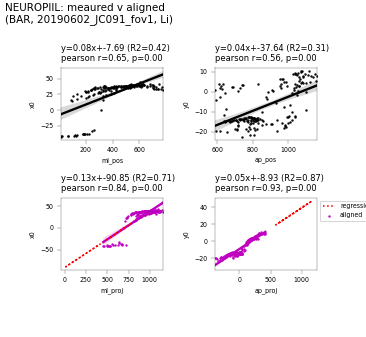

In [80]:
aligned_, M = sct.project_onto_gradient(curr_np, GVECTORS,    
                            xlabel='ml_pos', ylabel='ap_pos', abs_value=False)
aligned_np = pd.concat([curr_np, aligned_], axis=1).dropna()   
REGR_NP = sct.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')    
regr_np_meas = sct.regress_cortex_and_retino_pos(aligned_np, xvar='pos', model='ridge')  

print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

%matplotlib notebook
fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)
fig.text(0.01, 0.95, 'NEUROPIIL: meaured v aligned\n(BAR, %s, %s)' % (dk, va))

pl.subplots_adjust(bottom=0.4, right=0.65)

In [58]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

#### Load Neuropil data points

In [81]:
retinorun, AZMAP_NP, ELMAP_NP, GVECTORS = sct.load_vectors_and_maps(dk, va, 
                                                            create_new=False)

MEASURED:
|    |       R2 |     RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|---------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.418706 | 17.8171  | 5.09623e-22 |    0.647075 |     0.0833495 |    -8.18018 | az     |
|  1 | 0.312147 |  8.12183 | 1.13678e-15 |    0.558701 |     0.0350819 |   -37.6394  | el     |
ALIGNED:
|    |       R2 |     RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|---------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.668051 | 13.464   | 4.80945e-43 |    0.817344 |     0.128112  |   -94.3306  | az     |
|  1 | 0.868027 |  3.55753 | 1.49862e-77 |    0.93168  |     0.0484571 |    -8.24012 | el     |


<IPython.core.display.Javascript object>


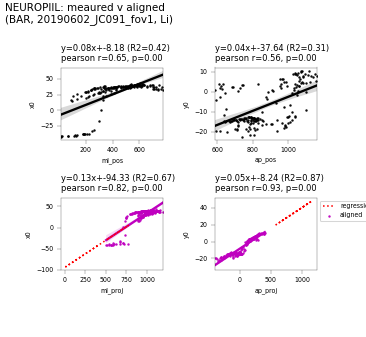

In [82]:
%matplotlib notebook

mag_thr=0.001
delay_map_thr=1.0
ds_factor=2
# # 1. Load neuropil background prefs
# retinodf_np = sct.load_neuropil_data(dk, retinorun, mag_thr=mag_thr, 
#                                 delay_map_thr=delay_map_thr, ds_factor=ds_factor)
# # 2. Align FOV to gradient vector direction 
# curr_np = retinodf_np[retinodf_np.visual_area==va].copy()
# aligned_, M = sct.project_onto_gradient(curr_np, GVECTORS,
#                                   xlabel='ml_pos', ylabel='ap_pos')
# aligned_np = pd.concat([retinodf_np, aligned_], axis=1).dropna()

# # 3. Use NEUROPIL to estimate linear model
# REGR_NP = sct.regress_cortex_and_retino_pos(aligned_np, xvar='proj', model='ridge')
# regr_np_meas = sct.regress_cortex_and_retino_pos(aligned_np, xvar='pos', model='ridge')
aligned_np, REGR_NP, regr_np_meas = sct.transform_and_fit_neuropil(dk, va, retinorun,
                                                    GVECTORS, mag_thr=mag_thr, 
                                                    delay_map_thr=delay_map_thr, 
                                                    ds_factor=ds_factor,
                                                                  abs_value=False)
# Save
# sct.update_models(dk, va, REGR_NP)

# Q:  why is reversal (LM) wonky
# Q:  fit SOMA to eitehr BAR or TILE gradient
print("MEASURED:")
print(regr_np_meas.to_markdown())
print("ALIGNED:")
print(REGR_NP.to_markdown())

%matplotlib notebook
fig = sct.plot_measured_and_aligned(aligned_np, REGR_NP, regr_np_meas)
fig.text(0.01, 0.95, 'NEUROPIIL: meaured v aligned\n(BAR, %s, %s)' % (dk, va))

pl.subplots_adjust(bottom=0.4, right=0.65)

#### Load soma

In [61]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

MEASURED:
|    |       R2 |    RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|--------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.415014 | 9.45643 | 1.02912e-06 |    0.644216 |     0.0584364 |      5.2826 | az     |
|  1 | 0.585701 | 6.47255 | 3.7354e-10  |    0.765311 |     0.0591338 |    -62.3361 | el     |
ALIGNED:
|    |       R2 |     RMSE |   pearson_p |   pearson_r |   coefficient |   intercept | cond   |
|---:|---------:|---------:|------------:|------------:|--------------:|------------:|:-------|
|  0 | 0.335705 | 10.0771  | 1.97849e-05 |    0.5794   |     0.0729667 |    -46.3279 | az     |
|  1 | 0.794999 |  4.55298 | 4.31417e-17 |    0.891627 |     0.0567902 |    -11.3999 | el     |


<IPython.core.display.Javascript object>


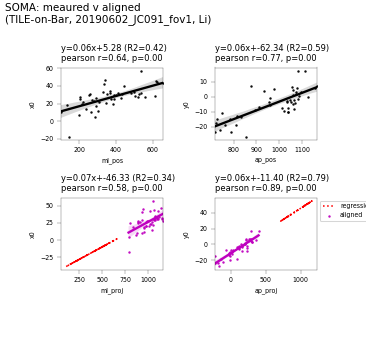

In [62]:
#### Align soma coords to gradient
aligned_soma = sct.predict_soma_from_gradient(dk, va, REGR_NP, experiment='rfs',
                                   response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction,
                                    abs_value=False)
#### (alrady done above, but get regr. values)
regr_soma_meas = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                   xvar='pos', model='ridge')
regr_soma_proj = sct.regress_cortex_and_retino_pos(aligned_soma, 
                                                    xvar='proj', model='ridge')
print("MEASURED:")
print(regr_soma_meas.to_markdown())
print("ALIGNED:")
print(regr_soma_proj.to_markdown())
# plot
fig = sct.plot_measured_and_aligned(aligned_soma, regr_soma_proj, regr_soma_meas)
fig.text(0.01, 0.95, 'SOMA: meaured v aligned\n(TILE-on-Bar, %s, %s)' % (dk, va))

pl.subplots_adjust(bottom=0.4, right=0.65)
# figname = 'compared_measured_vs_aligned_CTX_to_RETINO'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Plot

In [63]:
# output dir
rf_str = 'sphr_corrected' if do_spherical_correction else ''
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 'scatter/%s' % rf_str)
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    
FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'retinotopy', 'scatter/%s' % rf_str)
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

print(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/scatter/
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/retinotopy/scatter/


## predicted_vs_measured_fov_overlay

In [64]:
zimg, masks, ctrs = roiutils.get_masks_and_centroids(dk, traceid=traceid)
pixel_size = hutils.get_pixel_size()
zimg_r = retutils.transform_2p_fov(zimg, pixel_size)

In [65]:
inbounds_soma = aligned_soma[aligned_soma.inbounds].copy()

In [66]:
# Make sure we are in bounds of FOV
ap_lim, ml_lim = AZMAP_NP.shape
print(ap_lim, ml_lim)
incl_plotdf = inbounds_soma[(inbounds_soma['predicted_ml_pos']>=0) 
                            & (inbounds_soma['predicted_ml_pos']<=ml_lim) 
                            & (inbounds_soma['predicted_ap_pos']>=0)
                            & (inbounds_soma['predicted_ap_pos']<=ap_lim)].copy()
excl_ixs = [i for i in inbounds_soma.index.tolist() if i not in incl_plotdf.index]
plotdf = incl_plotdf.iloc[0::].copy()

vmin = min([np.nanmin(AZMAP_NP), plotdf['x0'].min()])
vmax = max([np.nanmax(AZMAP_NP), plotdf['x0'].max()])
print("AZ: min/max = %.2f, %.2f" % (vmin, vmax))
vmin = min([np.nanmin(ELMAP_NP), plotdf['y0'].min()])
vmax = max([np.nanmax(ELMAP_NP), plotdf['y0'].max()])
print("EL: min/max = %.2f, %.2f" % (vmin, vmax))


1177 972
AZ: min/max = -53.15, 48.78
EL: min/max = -26.69, 13.00


In [67]:
vmin = min([np.nanmin(AZMAP_NP), plotdf['x0'].min()])
vmax = max([np.nanmax(AZMAP_NP), plotdf['x0'].max()])
az_min=np.floor(vmin)
az_max=np.ceil(vmax)
vmin = min([np.nanmin(ELMAP_NP), plotdf['y0'].min()])
vmax = max([np.nanmax(ELMAP_NP), plotdf['y0'].max()])
el_min=np.floor(vmin)
el_max=np.ceil(vmax)

# az_min=5
# az_max=30
# el_min=-30
# el_max=-5

<IPython.core.display.Javascript object>


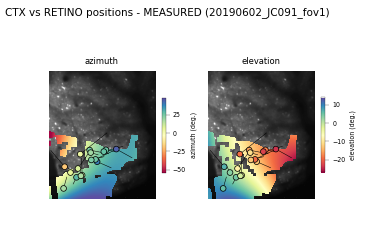

Text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (20190602_JC091_fov1)')

In [68]:
roi_interval = 1
cmap='Spectral'
plot_true=True
plot_predicted=False
plot_lines=True

color_true='k'
color_predicted='w'

markersize=30
lw=0.7
alpha=1

fig, axn = pl.subplots(1, 2, figsize=(6.5,4))
for ax, cond in zip(axn, ['azimuth', 'elevation']):
    neuropil_map = AZMAP_NP.copy() if cond=='azimuth' else ELMAP_NP.copy()
    retino_label='x0' if cond=='azimuth' else 'y0'
    # Set color limits
    vmin = az_min if cond=='azimuth' else el_min #min([np.nanmin(neuropil_map), plotdf[retino_label].min()])
    vmax = az_max if cond=='azimuth' else el_max #max([np.nanmax(neuropil_map), plotdf[retino_label].max()])
    normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    ax.set_title(cond)
    sm = pl.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    
    ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
    ax.imshow(neuropil_map, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.figure.colorbar(sm, ax=ax, shrink=0.5, label='%s (deg.)' % cond)
    
    if plot_predicted:
        # Plot soma
        sns.scatterplot(x='predicted_ml_pos', y='predicted_ap_pos', 
                data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_predicted, zorder=1000) 
    if plot_lines:
        # Plot connecting line
        for (x1, y1), (x2, y2) in zip(\
                plotdf[['predicted_ml_pos', 'predicted_ap_pos']].values,
                plotdf[['ml_pos', 'ap_pos']].values):
            ax.plot([x1, x2], [y1, y2], lw=0.5, markersize=0, color='k')
    if plot_true:
        # Plot soma
        sns.scatterplot(x='ml_pos', y='ap_pos', data=plotdf, ax=ax,
                alpha=alpha, hue=retino_label, hue_norm=normalize, palette=cmap,
                s=markersize, linewidth=lw, edgecolor=color_true, zorder=1000) 
for ax in axn:
    ax.legend_.remove()
    ax.axis('off')
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
fig.text(0.01, 0.95, 'CTX vs RETINO positions - MEASURED (%s)' % dk)

# figname = 'scatter_example_%s' % dk
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

# Calculate scatter

In [178]:
# Load scatter analysis for current FOV
scatter0 = sct.load_scatter_results(dk, va, experiment, verbose=False)
# Get cells with reliable fits
fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                do_spherical_correction=do_spherical_correction)
eval_results, eval_params = rfutils.load_eval_results(dk, experiment=experiment, 
                                traceid=traceid, fit_desc=fit_desc)   
reliable_ = rfutils.get_reliable_fits(eval_results['pass_cis'],
                                pass_criterion='position')
# Assign reliable index
found_rois = scatter0['cell'].unique()
scatter0['reliable'] = False
scatter0.loc[scatter0['cell'].isin(reliable_), 'reliable'] = True

In [179]:
# Identify "true deviants"
devs_ = sct.get_deviants_in_fov(dk, va, experiment=experiment, redo_fov=False,
                     traceid=traceid, response_type=response_type, 
                     do_spherical_correction=do_spherical_correction)               
devs_ = devs_.rename(columns={'deviants': 'cell'})
devs_['deviant'] = True
# merge
scatter_ = scatter0.merge(devs_, on=['cell', 'axis'], how='outer')
scatter_ = scatter_.fillna(value=False).sort_values(by=['cell', 'axis'])\
                   .reset_index(drop=True)

In [180]:
# Only get reliable
rois_ = np.intersect1d(reliable_, aligned_soma[aligned_soma.inbounds]['cell'].unique())
boot_ = eval_results['bootdf'][eval_results['bootdf']['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]
fitrfs_ = aligned_soma[aligned_soma['cell'].isin(rois_)].copy()
fitrfs_.index = fitrfs_['cell'].values

<IPython.core.display.Javascript object>


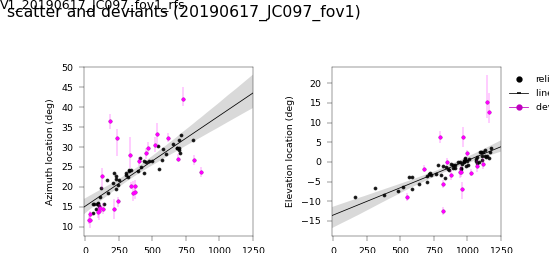

In [183]:
%matplotlib notebook
ci = 0.95
fill_marker=True
deviant_color='magenta'

fig, axn = pl.subplots(1, 2, figsize=(6.5,3), dpi=150, sharex=True)
for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
#     if cond=='az':
#         ax.set_ylim([0, 60])
#     else:
#         #pass
#         ax.set_ylim([-60, -0])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    ax.set_xlim([-10, 1250])
    # Get projected cortical position
    ax, devs_ = sct.fit_with_deviants(boot_, cis_, fitrfs_, 
                          xname=xname, yname=yname, ax=ax,
                          scatter_kws={'s': 2, 'marker': 'o'}, line_kws={'lw': 0.5}, 
                          deviant_color=deviant_color)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cortical position (um)')
    devdf = pd.DataFrame({'deviants': devs_})
    devdf['cond'] = cond
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.75, bottom=0.25, top=0.85, wspace=0.3)

leg_h = pplot.custom_legend_markers(colors=['k', 'k', 'm'],
                    labels=['reliable', 'linear fit (95% CI)', 'deviant (95% CI)'],
                    markers=['o', '_', 'o'], lws=[0, 0.5, 0.5])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left',
          frameon=False, fontsize=6, markerscale=0.5)

pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)

fig.text(0.01, 0.9, 'scatter and deviants (%s)' % dk, fontsize=8)
pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))

# figname = 'deviants_example_%s' % dk
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


In [184]:
fitrfs_[(fitrfs_.x0>20) & (fitrfs_.ml_proj<600)]

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds
37,29.787194,3.523769,27.457337,20.310999,6.274474,-0.003209,0.064675,0.573428,37,V1,...,1241.508355,27.215205,2.422856,670.242139,1094.860384,2.571988,1.100913,124.989655,67.884013,True
39,28.468079,2.576100,26.823645,21.658984,0.020461,-0.002368,0.063541,0.623277,39,V1,...,1183.073650,26.984221,2.333713,603.001314,1054.063627,1.483859,0.242388,72.110344,14.946014,True
43,26.539960,1.448276,23.598690,17.478454,0.202113,-0.002607,0.072106,0.665056,43,V1,...,1113.530256,25.917758,1.798412,505.896398,1010.648708,0.622202,-0.350136,30.236851,21.589931,True
48,22.406671,1.312235,22.681331,16.032212,6.241123,-0.001610,0.047623,0.551778,48,V1,...,1105.141750,24.274578,1.863306,308.190097,1061.352292,-1.867907,-0.551071,90.773767,33.979876,True
54,23.076621,1.056457,26.956937,16.308398,0.136952,-0.000272,0.068667,0.661150,54,V1,...,1089.370083,23.920734,2.221644,338.962356,1035.627470,-0.844113,-1.165186,41.020943,71.847215,True
61,22.847355,12.767858,24.683633,11.387274,5.363801,0.000603,0.251953,0.704631,61,V1,...,1811.513384,20.208036,2.217827,381.701951,1776.871694,2.639319,10.550032,128.261702,650.531464,True
87,21.684254,0.935927,21.591414,13.607556,0.141863,-0.005726,0.222441,0.555521,87,V1,...,1081.937967,21.004902,-0.672905,272.019356,1048.000641,0.679351,1.608832,33.014103,99.203076,True
91,21.823276,0.709326,23.488023,12.838041,0.041407,-0.001975,0.104760,0.735263,91,V1,...,1067.965436,22.807805,-0.738019,277.609747,1031.728413,-0.984529,1.447345,47.844651,89.245590,True
92,20.539933,2.177044,21.807394,17.133803,6.201981,-0.003690,0.103592,0.808495,92,V1,...,1158.467200,22.617124,-0.415692,223.143858,1142.616442,-2.077191,2.592736,100.944219,159.872135,True
133,36.496285,-1.688454,17.974285,8.875770,0.297407,0.000043,0.102357,0.585708,133,V1,...,920.114546,21.447410,-5.692348,966.257258,670.213374,15.048876,4.003894,731.322832,246.886397,True


In [47]:
importlib.reload(sct)

<module 'analyze2p.scatter' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/scatter.py'>

<IPython.core.display.Javascript object>


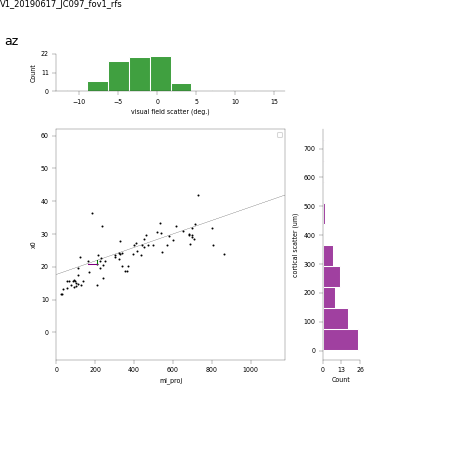

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


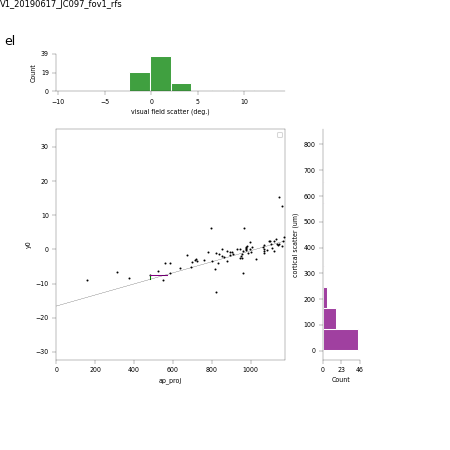

No handles with labels found to put in legend.


In [185]:
sz = 3
lw=0.5
nbins=10
color1='purple'
color2='green'

for cond in ['az', 'el']:
    dist_lim = ml_lim if cond=='az' else ap_lim
    fig = sct.plot_scatter_and_marginals(fitrfs_, REGR_NP, roi_to_label=None, #93,
                                         cond=cond,
                                        xlim=ap_lim, ylim=None, lw=1)
    pplot.label_figure(fig, '%s_%s_%s' % (va, dk, experiment))
    fig.text(0.01, 0.9, '%s' % cond, fontsize=12)
    pl.subplots_adjust(bottom=0.2, right=0.8)
    figname = 'scatter_marginals_%s_%s' % (cond, dk)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    #pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))


In [143]:
fitrfs_[fitrfs_['cell']==78]

,x0,y0,sigma_x,sigma_y,theta,offset,amplitude,r2,cell,visual_area,...,predicted_ap_proj,predicted_x0,predicted_y0,predicted_ml_pos,predicted_ap_pos,deg_scatter_x0,deg_scatter_y0,dist_scatter_ml,dist_scatter_ap,inbounds


In [303]:
int(np.where(fitrfs_['cell']==78)[0])



37